In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [1]:
import numpy as np
import pandas as pd
import os
import random
import librosa as libr
import librosa.display as disp
from IPython.display import Audio
from scipy.io import wavfile

In [2]:
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torchaudio.transforms import Resample
from torchsummary import summary
from torch.utils.data import SubsetRandomSampler,Subset,DataLoader
from torchmetrics.audio import ScaleInvariantSignalNoiseRatio
from torchmetrics.audio import pesq as PESQ

In [3]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda:0

NVIDIA RTX A5000
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [5]:
retrain = 0
save_per_epoch = 5
torch.manual_seed(0)

In [6]:
config = {
    'sample_rate':48000,
    'max_duration':4,
    'batch_size':16,
    'learning_rate': 0.0001,
    'lr_decay':(0.9, 0.999),
    'epochs':200,
}

In [ ]:
# !wget https://datashare.ed.ac.uk/bitstream/handle/10283/2791/clean_testset_wav.zip?sequence=1&isAllowed=y
# !wget https://datashare.ed.ac.uk/bitstream/handle/10283/2791/clean_trainset_28spk_wav.zip?sequence=2&isAllowed=y
# !wget https://datashare.ed.ac.uk/bitstream/handle/10283/2791/noisy_trainset_28spk_wav.zip?sequence=6&isAllowed=y
# !wget https://datashare.ed.ac.uk/bitstream/handle/10283/2791/noisy_testset_wav.zip?sequence=5&isAllowed=y

In [7]:
# !unzip "./data/noisy_trainset_28spk_wav.zip"
# !unzip "./data/clean_trainset_28spk_wav.zip"
# !unzip "./data/noisy_testset_wav.zip"
# !unzip "./data/clean_testset_wav.zip"

In [8]:
train_noisy_data_path = "./noisy_trainset_28spk_wav/"
train_clean_data_path = "./clean_trainset_28spk_wav/"
test_noisy_data_path = "./noisy_testset_wav/"
test_clean_data_path = "./clean_testset_wav/"

In [9]:
class AudioDataset(Dataset):
    def __init__(self,noisy_path,clean_path, transform=None, sample_rate=None,max_duration=None):

        #get file paths
        noisy_all_items = os.listdir(noisy_path)
        noisy_files = [item for item in noisy_all_items if os.path.isfile(os.path.join(noisy_path, item)) and item.lower().endswith('.wav')]
        noisy_file_paths = [os.path.join(noisy_path, file_name) for file_name in noisy_files]
        clean_file_paths = [os.path.join(clean_path, file_name) for file_name in noisy_files]

        #initialize variables
        self.noisy_data = noisy_file_paths
        self.clean_data = clean_file_paths
        self.transform = transform
        self.sample_rate = sample_rate
        self.max_duration = max_duration
        self.num_samples = sample_rate*max_duration

    def __len__(self):
        return len(self.noisy_data)

    def __getitem__(self, idx):
        noisy_waveform, sr = torchaudio.load(self.noisy_data[idx])
        if sr != config['sample_rate']:
            resampler = torchaudio.transforms.Resample(sr, config['sample_rate'])
            noisy_waveform = resampler(noisy_waveform)
        noisy_waveform = torch.tensor(noisy_waveform.numpy().reshape(-1))
        if noisy_waveform.shape[0] < self.num_samples:
            num_missing_samples = self.num_samples - noisy_waveform.shape[0]
            noisy_waveform = F.pad(noisy_waveform, (0, num_missing_samples))
        noisy_waveform = torch.tensor(noisy_waveform[:self.num_samples])

        clean_waveform, sr = torchaudio.load(self.clean_data[idx])
        if sr != config['sample_rate']:
            resampler = torchaudio.transforms.Resample(sr, config['sample_rate'])
            clean_waveform = resampler(clean_waveform)
        clean_waveform = torch.tensor(clean_waveform.numpy().reshape(-1))
        if clean_waveform.shape[0] < self.num_samples:
            num_missing_samples = self.num_samples - clean_waveform.shape[0]
            clean_waveform = F.pad(torch.tensor(clean_waveform), (0, num_missing_samples))
        clean_waveform = torch.tensor(clean_waveform[:self.num_samples])  
              
        return noisy_waveform, clean_waveform

In [10]:
def split_dataset(dataset, num=16):
    dataset_indices = list(range(len(dataset)))
    random.shuffle(dataset_indices)
    train_indices = dataset_indices[num:]
    val_indices = dataset_indices[:num]
    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    return train_dataset,val_dataset

In [11]:
train_dataset = AudioDataset(noisy_path=train_noisy_data_path,
                       clean_path=train_clean_data_path,
                       sample_rate=config['sample_rate'],
                       max_duration=config['max_duration'],
                       )
test_dataset = AudioDataset(noisy_path=test_noisy_data_path,
                       clean_path=test_clean_data_path,
                       sample_rate=config['sample_rate'],
                       max_duration=config['max_duration'],
                       )

train_dataset, val_dataset = split_dataset(train_dataset,16)

train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {config['batch_size']}")
print(f"Length of val dataloader: {len(val_dataloader)} batches of {config['batch_size']}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {config['batch_size']}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7fcca6abfe10>, <torch.utils.data.dataloader.DataLoader object at 0x7fcca64f77d0>)
Length of train dataloader: 722 batches of 16
Length of val dataloader: 2 batches of 16
Length of test dataloader: 52 batches of 16


In [12]:
train_len = len(train_dataloader)
val_len = len(val_dataloader)
test_len = len(test_dataloader)
print(train_len,val_len, test_len)

722 2 52


In [ ]:
# for i, data in enumerate(train_dataloader, 0):
#     print(i,data[0].shape,data[1].shape)
#     break

# for i, data in enumerate(val_dataloader, 0):
#     print(i,data[0].shape,data[1].shape)
    

# for i, data in enumerate(test_dataloader, 0):
#     print(i,data[0].shape,data[1].shape)
#     break

In [13]:
class Conv1D(nn.Module):
    def __init__(self,in_channels, out_channels, kernel_size,padding=0):
        super(Conv1D,self).__init__()
        self.conv1d = nn.Conv1d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size,padding=padding)
        self.activation = nn.ReLU()
        self.init_weights()
    
    def init_weights(self):
        torch.nn.init.kaiming_uniform_(self.conv1d.weight)
         
    def forward(self,x):
        x = self.conv1d(x)
        x = self.activation(x)
        return x
    
class Conv1DTranspose(nn.Module):
    def __init__(self,in_channels, out_channels, kernel_size,padding=0):
        super(Conv1DTranspose,self).__init__()
        self.conv1dtranspose = nn.ConvTranspose1d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size,padding=padding)
        self.activation = nn.ReLU()
        self.init_weights()
    
    def init_weights(self):
        torch.nn.init.kaiming_uniform_(self.conv1dtranspose.weight)
         
    def forward(self,x):
        x = self.conv1dtranspose(x)
        x = self.activation(x)
        return x
    
class WaveUNetModelsmall(nn.Module):
    def __init__(self):
        super(WaveUNetModelsmall,self).__init__() 
        self.down_conv_layer_1 = Conv1D(in_channels=1, out_channels=128, kernel_size=3)
        self.down_conv_layer_2 = Conv1D(in_channels=128, out_channels=32, kernel_size=3)
        # self.down_conv_layer_3 = Conv1D(in_channels=32, out_channels=16, kernel_size=3)
        # self.down_conv_layer_4 = Conv1D(in_channels=16, out_channels=8, kernel_size=3)

        # self.up_conv_layer_4 = Conv1DTranspose(in_channels=8, out_channels=16, kernel_size=3)
        # self.up_conv_layer_3 = Conv1DTranspose(in_channels=16, out_channels=32, kernel_size=3)
        self.up_conv_layer_2 = Conv1DTranspose(in_channels=32, out_channels=128, kernel_size=3)
        self.up_conv_layer_1 = Conv1DTranspose(in_channels=128, out_channels=1, kernel_size=3)

        self.conv1d = nn.Conv1d(in_channels=1,out_channels=1,kernel_size=3,padding='same')


    def forward(self,x):
        # print("x", x.shape)
        enc1 = self.down_conv_layer_1(x)
        # torch.nn.utils.clip_grad_norm_(self.down_conv_layer_1.parameters, 'max_norm', norm_type=2.0)
        # print("enc1", enc1.shape)
        enc2 = self.down_conv_layer_2(enc1)
        # print("enc2", enc1.shape)
        # enc3 = self.down_conv_layer_3(enc2)
        # # print("enc3", enc3.shape)
        # enc4 = self.down_conv_layer_4(enc3)
        # # print("enc4", enc4.shape)
        
        
        # dec4 = self.up_conv_layer_4(enc4)
        # # print("dec4", dec4.shape)
        # dec3 = self.up_conv_layer_3(dec4)
        # # print("dec3", dec3.shape)
        dec2 = self.up_conv_layer_2(enc2)
        # print("dec2", dec2.shape)
        dec1 = self.up_conv_layer_1(dec2)
        # print("dec1", dec1.shape)

        conv_op = self.conv1d(dec1)
        # print("final", final.shape)
        sig_output = torch.sigmoid(conv_op)
        # print("sig_output", sig_output.shape)
        return conv_op, sig_output

In [14]:
model = WaveUNetModelsmall()
model = model.to(device)


summary(model,input_size=(1, 19200), batch_size=16)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1           [16, 128, 19198]             512
              ReLU-2           [16, 128, 19198]               0
            Conv1D-3           [16, 128, 19198]               0
            Conv1d-4            [16, 32, 19196]          12,320
              ReLU-5            [16, 32, 19196]               0
            Conv1D-6            [16, 32, 19196]               0
   ConvTranspose1d-7           [16, 128, 19198]          12,416
              ReLU-8           [16, 128, 19198]               0
   Conv1DTranspose-9           [16, 128, 19198]               0
  ConvTranspose1d-10             [16, 1, 19200]             385
             ReLU-11             [16, 1, 19200]               0
  Conv1DTranspose-12             [16, 1, 19200]               0
           Conv1d-13             [16, 1, 19200]               4
Total params: 25,637
Trainable params: 

In [15]:
rand_inp = torch.randn(16, 1,192000).to(device)
rand_out = model(rand_inp)

In [24]:
model = WaveUNetModelsmall()
model = model.to(device)

if retrain:
  PATH = './denoise_e2e_model_48khz_small'
  model.load_state_dict(torch.load(PATH))
  print("loaded pretrained model..")
  
criterion = nn.BCELoss()
quant_criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'], betas=config['lr_decay'])
# early_stopping = optim.EarlyStopping(patience=config['patience'], verbose=True)

train_losses,val_losses = [],[]
# train_scores_ssnr,val_scores_ssnr = [],[]
# train_scores_pesq,val_scores_pesq = [],[]
num_epochs = 10#config['epochs']
intermediate_ouputs = {}

print("starting training..")
for epoch in range(1,num_epochs+1):

  model.train()
  epoch_loss,epoch_ssnr,epoch_pesq = 0.0,0.0,0.0

  for i, data in enumerate(train_dataloader, 0):
      # get the inputs; data is a list of [inputs, labels]
      X, y = data
      X = X.unsqueeze(1)
      X, y  = Variable(X.to(device)), Variable(y.to(device))

      optimizer.zero_grad()
      fn_val, preds = model(X)
      preds = preds.squeeze(1).to(device)
      
      loss = criterion(preds.float(), y.float())
      # ssnr_score = get_ssnr(preds, clean)
      # pesq_score = get_pesq(preds, clean)

      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(),max_norm=2.0)
      optimizer.step()


      mse_loss = quant_criterion(fn_val.float(),y.float())
      epoch_loss += mse_loss.item()
      
      # epoch_ssnr += ssnr_score
      # epoch_pesq += pesq_score
      
  train_losses.append(epoch_loss)
  # train_scores_ssnr.append(epoch_ssnr)
  # train_scores_pesq.append(epoch_pesq)
  #print(f'Training: Epoch {epoch}/{num_epochs} Loss: {epoch_loss:.4f} SSNR: {epoch_ssnr:.4f} PESQ: {epoch_pesq:.4f}')
  print(f'Training: Epoch {epoch}/{num_epochs} MSE Loss: {epoch_loss:.4f} MSE Lossperbatch: {epoch_loss/train_len:.4f}')
#   if((epoch == 1) or (epoch%50 == 0)):
#     intermediate_ouputs[str(epoch)] = save_inter_ouput(model,mel_spectrogram)

      
  #Validation
  model.eval()
  val_loss,val_ssnr,val_pesq = 0.0,0.0,0.0
  with torch.no_grad():
    for i, data in enumerate(val_dataloader, 0):
      X_val, y_val = data
      X_val = X_val.unsqueeze(1)
      X_val, y_val = Variable(X_val.to(device)), Variable(y_val.to(device))

      fn_val,pred = model(X_val)
      val_loss += quant_criterion(pred.squeeze(1).to(device).float(), y_val.float()).item()
      # val_ssnr += get_ssnr(preds_val, clean)
      # val_pesq += get_pesq(preds_val, clean)
 
  val_losses.append(val_loss)
  # val_scores_ssnr.append(val_ssnr)
  # val_scores_pesq.append(val_pesq)
  # print(f'Validation: Epoch {epoch}/{num_epochs} Loss: {val_loss:.4f} SSNR: {val_ssnr:.4f} PESQ: {epoch_pesq:.4f}')
  print(f'Validation: MSE Loss: {val_loss:.4f} MSE Lossperbatch: {val_loss/val_len:.4f}')
  if (epoch%save_per_epoch == 0):
    PATH = './denoise_e2e_model_48khz_small'
    torch.save(model.state_dict(), PATH)
  print("=======================================")


starting training..
Training: Epoch 1/10 MSE Loss: 143.2996 MSE Lossperbatch: 0.1985
Validation: MSE Loss: 0.7022 MSE Lossperbatch: 0.3511
Training: Epoch 2/10 MSE Loss: 80.3679 MSE Lossperbatch: 0.1113
Validation: MSE Loss: 0.6619 MSE Lossperbatch: 0.3309
Training: Epoch 3/10 MSE Loss: 50.3712 MSE Lossperbatch: 0.0698
Validation: MSE Loss: 0.6228 MSE Lossperbatch: 0.3114
Training: Epoch 4/10 MSE Loss: 27.7893 MSE Lossperbatch: 0.0385
Validation: MSE Loss: 0.5849 MSE Lossperbatch: 0.2925
Training: Epoch 5/10 MSE Loss: 12.3864 MSE Lossperbatch: 0.0172
Validation: MSE Loss: 0.5483 MSE Lossperbatch: 0.2741
Training: Epoch 6/10 MSE Loss: 4.0165 MSE Lossperbatch: 0.0056
Validation: MSE Loss: 0.5128 MSE Lossperbatch: 0.2564
Training: Epoch 7/10 MSE Loss: 2.5829 MSE Lossperbatch: 0.0036
Validation: MSE Loss: 0.4787 MSE Lossperbatch: 0.2393
Training: Epoch 8/10 MSE Loss: 8.0180 MSE Lossperbatch: 0.0111
Validation: MSE Loss: 0.4459 MSE Lossperbatch: 0.2229
Training: Epoch 9/10 MSE Loss: 20.2704

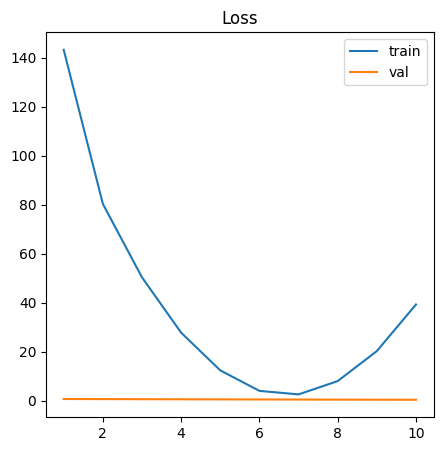

In [25]:
plt.figure(figsize=(5, 5))

# plt.subplot(1, 3, 1)
x = [i for i in range(1,len(train_losses)+1)]
plt.plot(x,train_losses, label='train')
plt.plot(x,val_losses, label='val')
plt.title('Loss')
plt.savefig('end2end_loss_48khz.png')
plt.legend()

In [32]:
model = WaveUNetModelsmall()
model = model.to(device)

PATH = './denoise_e2e_model_48khz_small'
model.load_state_dict(torch.load(PATH))
print("loaded pretrained model..")
  

loaded pretrained model..


In [33]:
test_audio,test_outputs = next(iter(test_dataloader))
outputs,k = model(test_audio.unsqueeze(dim=1).to(device))
k = k.squeeze(1).cpu().data.numpy()
outputs = outputs.squeeze(1).cpu().data.numpy()

In [34]:
Audio(test_audio[0],rate=48000)

In [35]:
Audio(test_outputs[0],rate=48000)

In [36]:
Audio(outputs[0],rate=48000)

In [37]:
Audio(k[0],rate=48000)

In [ ]:
model.eval()
test_loss,test_ssnr,test_pesq = 0.0,0.0,0.0
with torch.no_grad():
  for i, data in enumerate(test_dataloader, 0):
    X, y = data
    X = X.unsqueeze(1)
    X, y = Variable(X.to(device)), Variable(y.to(device))

    preds,_ = model(X)
    preds = preds.squeeze(1).to(device)
    print(preds.shape, y.shape,x.shape)
    loss,_ = criterion(preds.float(), y.float())
    # ssnr_score = get_ssnr(preds, clean)
    # pesq_score = get_pesq(preds, clean)

    test_loss += loss.item()
    # test_ssnr += ssnr_score
    # test_pesq += pesq_score

print(f'Test: Loss: {test_loss:.4f} Test: Lossperbatch: {test_loss/test_len:.4f} ')#SSNR: {test_ssnr:.4f} PESQ: {test_pesq:.4f}')

In [ ]:
# ssnr_fs = 22050
# ssnr = ScaleInvariantSignalNoiseRatio().to(device)

# def get_ssnr(preds, clean):
#     print(preds.shape, clean.shape)
#     inv_mel = preds.cpu().data.numpy()
#     S = libr.feature.inverse.mel_to_stft(inv_mel, sr=ssnr_fs)#config['sample_rate'])
#     preds_audio = libr.griffinlim(S)
#     ssnr_score = ssnr(preds_audio,clean).item()
#     return ssnr_score

In [ ]:
# get_pesq_fs = 16000
# pesq = PESQ.PerceptualEvaluationSpeechQuality(get_pesq_fs,'nb').to(device)

# def get_pesq(preds, clean):
#     inv_mel = preds.cpu().data.numpy()
#     S = libr.feature.inverse.mel_to_stft(inv_mel, sr=ssnr_fs)#config['sample_rate'])
#     preds_audio = libr.griffinlim(S)
#     resampler = Resample(orig_freq=config['sample_rate'], new_freq=get_pesq_fs).to(device)
#     preds_resample = resampler(preds_audio)
#     clean_resample = resampler(clean)
#     pesq_score = pesq(preds_resample,clean_resample).item()
#     return pesq_score

In [ ]:
def sample_preprop():
    sample_path = './noisy_testset_wav/p232_001.wav'
    num_samples = config['max_duration']*config['sample_rate']

    noisy_sample, sr = torchaudio.load(sample_path)
    noisy_waveform = torch.tensor(noisy_sample.numpy().reshape(-1))
    if noisy_waveform.shape[0] < num_samples:
        num_missing_samples = num_samples - noisy_waveform.shape[0]
        noisy_waveform = F.pad(noisy_waveform, (0, num_missing_samples))
    noisy_waveform = torch.tensor(noisy_waveform[:num_samples])
    return noisy_waveform
sample_noisy_waveform = sample_preprop()
print(sample_noisy_waveform.shape)

In [ ]:
def save_inter_ouput(model,transform):
    noisy_waveform = sample_noisy_waveform.to(device)
    model = model.to(device)
    
    model.eval()
    pred = model(noisy_waveform).squeeze(1).squeeze(0)
    mel = pred.cpu().data.numpy()
    S = libr.feature.inverse.mel_to_stft(mel, sr=config['sample_rate'])
    pred_audio = libr.griffinlim(S)
    return pred_audio

In [ ]:
plt.figure(figsize=(5, 5))

# plt.subplot(1, 3, 1)
x = [i for i in range(1,len(train_losses)+1)]
plt.plot(x,train_losses, label='train')
plt.plot(x,val_losses, label='val')
plt.title('Loss')
plt.legend()

# plt.subplot(1, 3, 2)
# plt.plot(torch.tensor(train_scores_ssnr), label='train')
# plt.plot(torch.tensor(val_scores_ssnr), label='val')
# plt.title('SSNR Scores')
# plt.legend()

# plt.subplot(1, 3, 3)
# plt.plot(train_scores_pesq, label='train')
# plt.plot(val_scores_pesq, label='test')
# plt.title('PESQ Scores')
# plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
for k in intermediate_ouputs.keys():
    print(k, intermediate_ouputs[k].shape)

In [ ]:
k = '1'
plt.figure(figsize=(5,3))
plt.plot(intermediate_ouputs[k])

filtered_sample_path = 'pred_400.wav'
wavfile.write(filtered_sample_path, 48000, intermediate_ouputs[k])
Audio(intermediate_ouputs[k],rate=48000)


In [ ]:
k = '50'
plt.figure(figsize=(5,3))
plt.plot(intermediate_ouputs[k])

filtered_sample_path = './pred_450.wav'
wavfile.write(filtered_sample_path, 48000, intermediate_ouputs[k])
Audio(intermediate_ouputs[k],rate=48000)



In [ ]:
k = '100'
plt.figure(figsize=(5,3))
plt.plot(intermediate_ouputs[k])

filtered_sample_path = 'pred_500.wav'
wavfile.write(filtered_sample_path, 48000, intermediate_ouputs[k])
Audio(intermediate_ouputs[k],rate=48000)



In [ ]:
outputs.shape

In [ ]:
test_audio.shape

In [ ]:
test_outputs.shape

In [ ]:
n_stft = config['n_fft'] // 2 + 1 
inverse_mel = torchaudio.transforms.InverseMelScale(sample_rate=config['sample_rate'],
                                                      n_mels=config['n_mels'],
                                                      n_stft=n_stft)
inverse_wave = inverse_mel(mel)
inverse_wave

In [ ]:
n = 2048
waveform, sample_rate = torchaudio.load("./clean_testset_wav/p232_001.wav")
mel_spectrogram_transform = torchaudio.transforms.MelSpectrogram(sample_rate, n_fft=n)
mel_spectrogram = mel_spectrogram_transform(waveform)
inverse_melscale_transform = torchaudio.transforms.InverseMelScale(n_stft=int(n // 2 + 1))
spectrogram = inverse_melscale_transform(mel_spectrogram)
inv_transform = torchaudio.transforms.GriffinLim(n_fft=n)
pred_waveform = inv_transform(spectrogram)

pred_waveform = pred_waveform.squeeze()
Audio(pred_waveform,rate=sample_rate)


In [ ]:
s = waveform.squeeze()
plt.plot(s)
Audio(s,rate=sample_rate)

In [ ]:
ps = pred_waveform.squeeze().abs()
plt.plot(ps)
Audio(ps,rate=sample_rate)

In [ ]:
waveform, sample_rate = torchaudio.load("./clean_testset_wav/p232_001.wav")

n_fft = 512

n_stft = int((n_fft//2) + 1)
transofrm = torchaudio.transforms.MelSpectrogram(sample_rate, n_fft=n_fft)
invers_transform = torchaudio.transforms.InverseMelScale(sample_rate=sample_rate, n_stft=n_stft)
grifflim_transform = torchaudio.transforms.GriffinLim(n_fft=n_fft)

mel_specgram = transofrm(waveform)
inverse_waveform = invers_transform(mel_specgram)
pseudo_waveform = grifflim_transform(inverse_waveform)

Audio(pseudo_waveform, rate=sample_rate)

In [ ]:
Audio(waveform, rate=48000)

In [ ]:
waveform, sample_rate = torchaudio.load("./clean_testset_wav/p232_001.wav")
spectrogram_transform = torchaudio.transforms.Spectrogram(sample_rate,power=None)
spectrogram = spectrogram_transform(waveform)#.type(torch.complex64)
inverse_transform = torchaudio.transforms.InverseSpectrogram(sample_rate)
pred_waveform = inverse_transform(spectrogram)



In [ ]:
waveform.shape,pred_waveform.shape

In [ ]:
Audio(waveform, rate=48000)

In [ ]:
Audio(pred_waveform, rate=48000)

In [ ]:
def get_sample_predicted_ouputs(id=0):
  test_audio,test_outputs = next(iter(test_dataloader))
  outputs = model(test_audio.unsqueeze(dim=1).to(device)).squeeze(1)
  print(test_audio[id].shape,test_outputs[id].shape, outputs.shape)
  return test_audio[id],test_outputs[id],outputs[id]

In [ ]:
audio_outputs = get_sample_predicted_ouputs(id=5)

In [ ]:
Audio(audio_outputs[0], rate=16000)

In [ ]:
Audio(audio_outputs[1], rate=16000)

In [ ]:
Audio(audio_outputs[2], rate=16000)

In [ ]:
S1,S2,S3 = mel_outputs
S3 = S3.cpu().detach().numpy()
plt.figure(figsize=(12, 2))

plt.subplot(1, 3, 1)
S_dB = libr.power_to_db(S1, ref=np.max)
img = libr.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=config['sample_rate'],
                         fmax=8000)
plt.title('Noisy')

plt.subplot(1, 3, 2)
S_dB = libr.power_to_db(S2, ref=np.max)
img = libr.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=config['sample_rate'],
                         fmax=8000)
plt.title('Clean')

plt.subplot(1, 3, 3)
S_dB = libr.power_to_db(S3, ref=np.max)
img = libr.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=config['sample_rate'],
                         fmax=8000)
plt.title('Predicted')
plt.colorbar(format='%2.0f')
plt.savefig('mel_pred_600.png')
plt.show()


In [ ]:
# S = mel_outputs[2].cpu().detach().numpy()

# fig, ax = plt.subplots()
# S_dB = libr.power_to_db(S, ref=np.max)
# img = libr.display.specshow(S_dB, x_axis='time',
#                          y_axis='mel', sr=config['sample_rate'],
#                          fmax=8000, ax=ax)
# fig.colorbar(img, ax=ax, format='%+2.0f dB')
# ax.set(title='Mel-frequency spectrogram')
# # plt.savefig('pred.png')

In [ ]:
S1,S2,S3 = audio_outputs[0].numpy(),audio_outputs[1].numpy(),audio_outputs[2]
plt.figure(figsize=(12, 3))

plt.subplot(1, 3, 1)
disp.waveshow(S1,sr=config['sample_rate'])
plt.title('Noisy')

plt.subplot(1, 3, 2)
disp.waveshow(S2,sr=config['sample_rate'])
plt.title('Clean')

plt.subplot(1, 3, 3)
disp.waveshow(S3,sr=config['sample_rate'])
plt.title('Predicted')
plt.savefig('sig_pred_600.png')
plt.show()

In [ ]:
plt.figure(figsize=(12, 3))
disp.waveshow(S1,sr=config['sample_rate'],label='Noisy')
disp.waveshow(S2,sr=config['sample_rate'],label='Clean')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12, 3))
disp.waveshow(S3,sr=config['sample_rate'],label='Prediction')
disp.waveshow(S2,sr=config['sample_rate'],label='Clean')
plt.legend()
plt.show()

In [ ]:
# use torch metrics
# use a baseline model network
# use torch summary tensor board, callback

In [ ]:
def get_sample_predicted_ouputs(id=0):
  test_audio,test_outputs, noisy_audio, clean_audio = next(iter(test_dataloader))
  outputs = model(test_audio.unsqueeze(dim=1).to(device)).squeeze(1)
  mel = outputs[id].cpu().data.numpy()
  S = libr.feature.inverse.mel_to_stft(mel, sr=config['sample_rate'])
  pred_audio = libr.griffinlim(S)
  print(noisy_audio[id].shape,clean_audio[id].shape, pred_audio.shape)
  print(test_audio[id].shape,test_outputs[id].shape, outputs[id].shape)
  return [noisy_audio[id],clean_audio[id], pred_audio],[test_audio[id],test_outputs[id],outputs[id]]

In [ ]:
PATH = './denoise_model_'+str(num_epochs)
torch.save(model.state_dict(), PATH)

In [ ]:
PATH = './denoise_model_200'
model = BaseUNetModel()
model = model.to(device)
model.load_state_dict(torch.load(PATH))

In [ ]:
def calculate_test_PESQ(data_loader):
    scores,pred_scores = [],[]
    pesq = PESQ.PerceptualEvaluationSpeechQuality(fs=16000,mode='wb')
    for i,data in enumerate(data_loader, 0):
        X,y,noise,clean = data
        score = pesq(noise.unsqueeze(0),clean.unsqueeze(0)).item()
        scores.append(score)

        outputs = model(X.unsqueeze(dim=1).to(device)).squeeze(1)
        mel = outputs.cpu().data.numpy()
        S = libr.feature.inverse.mel_to_stft(mel, sr=config['sample_rate'])
        pred_audio = libr.griffinlim(S)
        print(pred_audio)
        pred_score = pesq(pred_audio.unsqueeze(0),clean.unsqueeze(0)).item()
        pred_scores.append(pred_score)

    return np.mean(scores,),np.mean(pred_scores)

In [ ]:
mean_score, pred_mean_score = calculate_test_PESQ(test_dataloader)
mean_score,pred_mean_score

In [ ]:
def calculate_test_SSNR(data_loader):
    scores,pred_scores = [],[]
    ssnr = ScaleInvariantSignalNoiseRatio()
    for i,data in enumerate(data_loader, 0):
        X,y,noise,clean = data
        score = ssnr(noise.unsqueeze(0),clean.unsqueeze(0)).item()
        scores.append(score)

        # outputs = model(X.unsqueeze(dim=1).to(device)).squeeze(1)
        # mel = outputs[id].cpu().data.numpy()
        # S = libr.feature.inverse.mel_to_stft(mel, sr=config['sample_rate'])
        # pred_audio = libr.griffinlim(S)

        # pred_score = ssnr(pred_audio.unsqueeze(0),clean.unsqueeze(0)).item()
        # pred_scores.append(pred_score)

    return np.mean(scores,),np.mean(pred_scores)

In [ ]:
mean_score, pred_mean_score = calculate_test_SSNR(test_dataloader)
mean_score,pred_mean_score